In [1]:
import sys
import os
import xarray as xr
import numpy as np
import ultraplot as uplt
from pathlib import Path

# --- CONFIGURACIÓN DE RUTAS ---
current_dir = Path(os.path.abspath(''))
PROJECT_ROOT = current_dir.parent
sys.path.append(str(PROJECT_ROOT))

print(f"Raíz del proyecto: {PROJECT_ROOT}")

# Rutas de archivos
HISTORICAL_NC = PROJECT_ROOT / "outputs" / "evaluacion_historica.nc"
FUTURE_NC = PROJECT_ROOT / "outputs" / "prediccion_futuro_2064.nc"

# --- CARGAR DATOS ---
data_dict = {}

if HISTORICAL_NC.exists():
    print(f"Cargando Histórico: {HISTORICAL_NC.name}")
    ds_hist = xr.open_dataset(HISTORICAL_NC)
    data_dict['hist_real'] = ds_hist['realidad']
    data_dict['hist_pred'] = ds_hist['prediccion']

if FUTURE_NC.exists():
    print(f"Cargando Futuro: {FUTURE_NC.name}")
    ds_fut = xr.open_dataset(FUTURE_NC)
    data_dict['fut_pred'] = ds_fut['prw_futuro']
    data_dict['base_recent'] = ds_fut['prw_base'] # Base 1994-2014

# Verificar
if not data_dict:
    print("No se encontraron archivos .nc. Analizar si se corrio el pipeline correcto")
else:
    print("Datos listos para análisis.")

Raíz del proyecto: /mnt/beegfs/home/caliste/Proyecto_Clima_ML
Cargando Histórico: evaluacion_historica.nc
Cargando Futuro: prediccion_futuro_2064.nc
Datos listos para análisis.


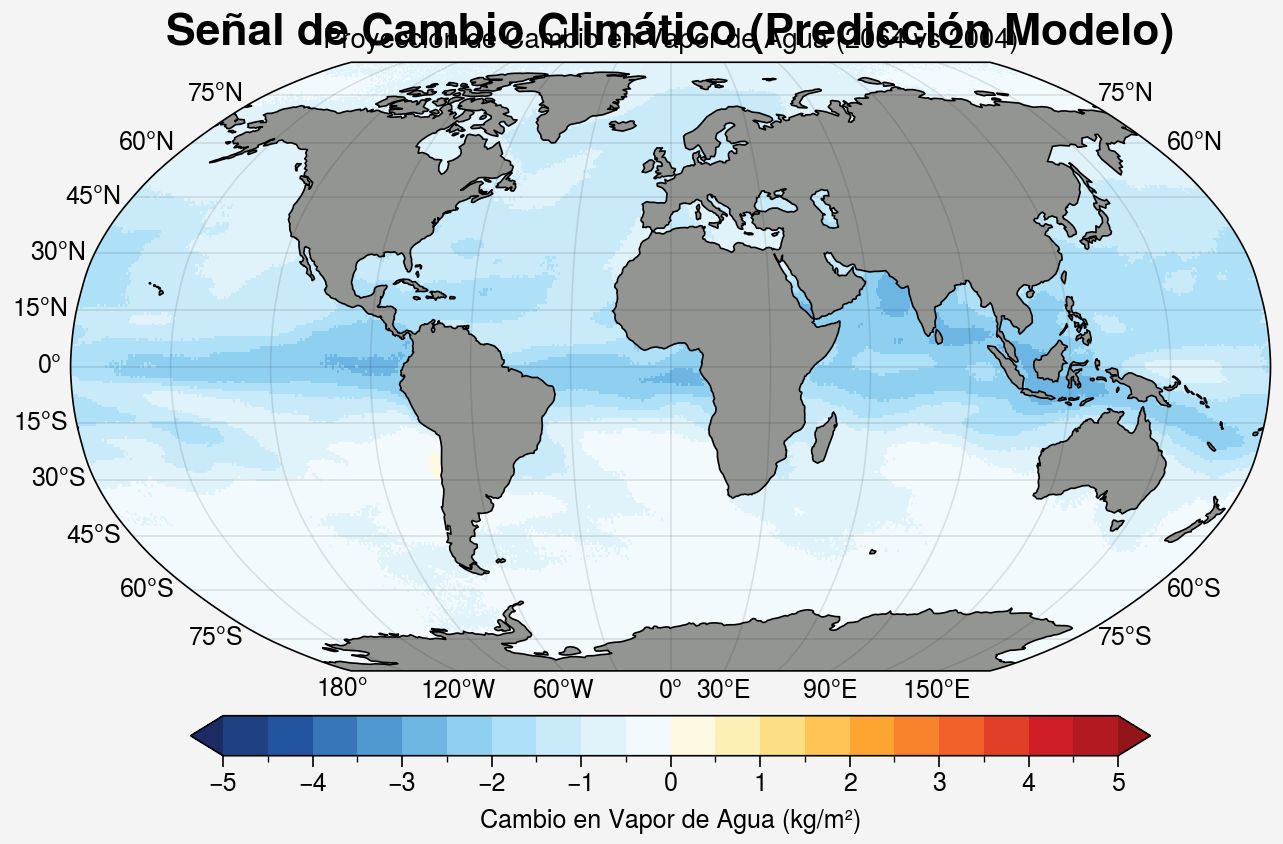

In [2]:
if 'fut_pred' in data_dict and 'base_recent' in data_dict:
    
    # Calcular el "Delta" (Cambio Futuro - Presente)
    # Esto nos dice dónde se intensificará el ciclo hidrológico
    climate_change_signal = data_dict['fut_pred'] - data_dict['base_recent']
    
    # --- GRÁFICO ---
    fig, axs = uplt.subplots(refwidth=6, proj='robin')

    m = axs[0].pcolormesh(
        climate_change_signal.lon, 
        climate_change_signal.lat, 
        climate_change_signal, 
        cmap='ColdHot', 
        levels=uplt.arange(-5, 5, 0.5),
        extend='both'
    )
    
    axs[0].format(
        title='Proyección de Cambio en Vapor de Agua (2064 vs 2004)',
        land=True, landcolor='gray', 
        coast=True, labels=True,
        lonlines=30, latlines=15
    )
    
    axs[0].colorbar(m, loc='b', label='Cambio en Vapor de Agua (kg/m²)', length=0.8)
    
    #fig.suptitle('Señal de Cambio Climático con MLP', fontsize=16)
    uplt.show()
else:
    print("Faltan datos futuros para este gráfico.")

In [ ]:
import pandas as pd
import numpy as np
import ultraplot as uplt

# Diagnóstico previo
if 'hist_real' in data_dict and 'hist_pred' in data_dict:
    print("Datos encontrados. Generando gráficos corregidos...")
    
    # Función auxiliar para extraer datos por zona (Asegurando numpy puro)
    def get_zone_values(da, lat_min, lat_max):
        # Seleccionar latitud, aplanar y devolver solo los VALORES NUMPY (sin pandas)
        return da.sel(lat=slice(lat_min, lat_max)).values.flatten()

    # 1. Extraer datos puros (Numpy Arrays)
    real = data_dict['hist_real']
    pred = data_dict['hist_pred']
    
    # Trópicos (-23 a 23)
    t_real = get_zone_values(real, -23, 23)
    t_pred = get_zone_values(pred, -23, 23)
    
    # Polos (60 a 90)
    p_real = get_zone_values(real, 60, 90)
    p_pred = get_zone_values(pred, 60, 90)
    
    print(f"Puntos en Trópicos: {len(t_real)}")
    print(f"Puntos en Polos: {len(p_real)}")

    # --- GRÁFICO DE DENSIDAD (KDE) ---
    fig, axs = uplt.subplots(ncols=2, share=False, refwidth=4)
    
    # Panel A: Trópicos (Zona Húmeda)
    axs[0].hist(
        [t_real, t_pred], 
        bins=50, alpha=0.6, density=True, 
        labels=['Realidad', 'Predicción IA'], 
        cycle=['blue7', 'red7'] 
    )
    axs[0].format(title='Distribución en los Trópicos', xlabel='Vapor de Agua (kg/m²)', ylabel='Densidad')
    axs[0].legend(loc='ur')
    
    # Panel B: Polos (Zona Seca)
    axs[1].hist(
        [p_real, p_pred], 
        bins=50, alpha=0.6, density=True, 
        labels=['Realidad', 'Predicción IA'], 
        cycle=['blue7', 'red7']  # <--- AQUÍ TAMBIÉN
    )
    axs[1].format(title='Distribución en los Polos (Norte)', xlabel='Vapor de Agua (kg/m²)')
    
    fig.suptitle('Validación Estadística Regional', fontsize=14)
    uplt.show()

else:
    print("ERROR: Faltan datos. Corre la celda anterior primero.")

Datos encontrados. Generando gráficos corregidos...
Puntos en Trópicos: 33792
Puntos en Polos: 21504


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
